# 논문 예시 구현
## 목적 :
High-Resolution Characterization of Near-surface Stuctures by Surface-Wave Inversions: From Dispersion Curve to Full Waveform에서 제시된 check boarch 역산을 구현한다.
## 조건
초기 모델 : Vp : 500 m/s, Vs : 200 m/s, Density : 2000kg/m3  
checker board : 1m by 1m - Vs만 바뀜 10% (220m/s or 180m/s)  
![checker](checker.png)

Geophone : 24개씩 1m 간격  
Source : 6개, 6m 간격, 40Hz ricker, offset ~ 3m 

## FWI
MFWI : 20, 40, 60, 80, 100Hz로 점점 low-cut filter를 건다



In [1]:
import torch
import deepwave
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

from Tools.processing import normalized_shot_gather
from Tools.soft_dtw_cuda import SoftDTW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Tools import read, model, plot, processing, inv
import scipy
import random

In [2]:
def create_checkerboard_model_robust(
    nx, nz, dx, dz,
    vs_initial, perturbation,
    checker_region_m, checker_size_m
):
    """
    격자 간격을 고려하여 체커보드 형태의 Vs 속도 모델을 생성합니다. (Robust version)

    Args:
        nx (int): x 방향 전체 격자점의 수.
        nz (int): z 방향 전체 격자점의 수.
        dx (float): x 방향 격자 간격 (m).
        dz (float): z 방향 격자 간격 (m).
        vs_initial (float): 배경 S파 속도 (m/s).
        perturbation (float): 속도 변화율 (예: 0.1은 10%).
        checker_region_m (tuple): (start_x_m, end_x_m, start_z_m, end_z_m) 미터 단위 체커보드 영역.
        checker_size_m (tuple): (size_x_m, size_z_m) 미터 단위 체커 하나의 크기.

    Returns:
        torch.Tensor: 최종 Vs 속도 모델.
    """
    # 1. 배경 속도 모델 생성
    vs_model = torch.full((nz, nx), vs_initial, dtype=torch.float32)

    # 2. 미터 단위를 격자 인덱스로 변환
    start_x = int(checker_region_m[0] / dx)
    end_x = int(checker_region_m[1] / dx)
    start_z = int(checker_region_m[2] / dz)
    end_z = int(checker_region_m[3] / dz)

    # 3. 체커 하나의 크기를 격자점 수로 변환
    checker_nx = int(checker_size_m[0] / dx)
    checker_nz = int(checker_size_m[1] / dz)

    # 4. 체커보드 영역의 인덱스 그리드 생성
    z_indices = torch.arange(start_z, end_z).unsqueeze(1)
    x_indices = torch.arange(start_x, end_x).unsqueeze(0)

    # 5. 격자 간격을 고려한 체커보드 패턴 생성
    # floor division을 통해 각 격자점이 몇 번째 체커에 속하는지 계산
    z_pattern = torch.floor(z_indices / checker_nz)
    x_pattern = torch.floor(x_indices / checker_nx)
    
    # 좌상단이 음의 섭동이 되도록 패턴 생성 (-1과 1)
    pattern = (z_pattern + x_pattern) % 2
    final_pattern = -((pattern * 2) - 1)

    # 6. 속도 변화량 계산 및 적용
    vs_delta = vs_initial * perturbation
    vs_model[start_z:end_z, start_x:end_x] += final_pattern * vs_delta

    return vs_model

In [3]:
offset = 3 #m
src_spacing = 6 #m
n_gp = 24
gp_spacing = 1 #m

geophone = np.arange(0, gp_spacing * n_gp, gp_spacing)
x_m = 40
z_m = 10
dx = 0.2

nx = int(x_m/dx)
nz = int(z_m / dx)

In [4]:
shots = torch.arange(5, 40, 6).to(device=device) /dx
receiver = torch.arange(8, 32, gp_spacing).to(device=device) / dx

In [5]:
vs_back = 200
vp_back = 500
rho_back = 2000

In [6]:
fs = 1000
dt = 1/fs
t= 0.5
nt = int(t/dt)
time = np.arange(0, dt * nt, dt)

In [7]:
region_orig = (10.0, 31.0, 2.0, 8.0) # 미터 단위
checker_orig = (1.0, 1.0)          # 미터 단위

In [8]:
original_model = create_checkerboard_model_robust(
    nx=nx, nz=nz, dx=dx, dz=dx,
    vs_initial=200.0, perturbation=0.10,
    checker_region_m=region_orig, checker_size_m=checker_orig
)

In [9]:
original_model = original_model.to(device)

In [10]:
V_MAX = 220
V_MIN = 180
data_range = V_MAX - V_MIN

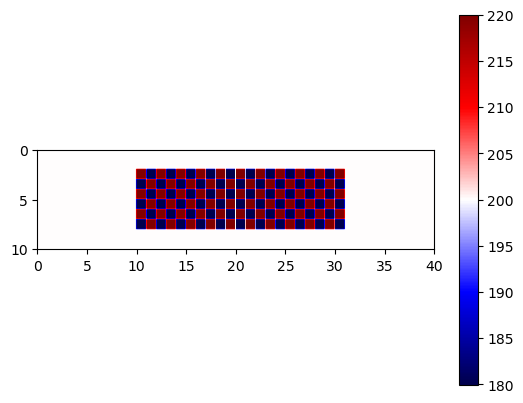

In [11]:
plt.figure()
plt.imshow(original_model.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

In [12]:
vp_f, vs_inv, rho_f = torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device)
vp_f[:,:] = vp_back
vs_inv[:,:] = vs_back
rho_f[:,:] = rho_back

In [13]:
n_shots = len(shots)
n_sources_per_shot = 1

f0 = 40
peak_time = 1.5/f0

source_amplitudes = (
    (deepwave.wavelets.ricker(f0, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

shot = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
shot[..., 0] = 2
shot[..., 1] = (shots).unsqueeze(1)

In [14]:
receiver_locations = torch.zeros(n_shots, len(receiver), 2, dtype=torch.long, device=device)
receiver_locations[..., 0] = 0
receiver_locations[:, :, 1] = receiver

In [15]:
obs = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, original_model, rho_f),
    grid_spacing=dx, dt=dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=shot,
    receiver_locations_y=receiver_locations,
    pml_freq=f0, pml_width=[0, 10, 10, 10]
)[-2]
obs = normalized_shot_gather(obs)

In [16]:
print(obs.shape)

torch.Size([6, 24, 500])


In [17]:
def csg(
    data, receiver, time,
    duration: float,
    title: str,
    color=None,
    second_data=None,
    second_color=None,
    show_legend: bool = True
):
    # numpy 변환
    if hasattr(data, 'detach'):
        data = data.detach().cpu().numpy()
    if second_data is not None and hasattr(second_data, 'detach'):
        second_data = second_data.detach().cpu().numpy()
    if hasattr(receiver, 'detach'):
        receiver = receiver.detach().cpu().numpy()

    dt      = time[1] - time[0]
    max_idx = int(duration / dt)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 합성파
    for i in range(data.shape[0]):
        trace = data[i, :max_idx]
        norm  = trace / np.max(np.abs(trace))
        ax.plot(receiver[i] + norm, time[:max_idx],
                color=color)

    # 관측파
    if second_data is not None:
        for i in range(second_data.shape[0]):
            trace = second_data[i, :max_idx]
            norm  = trace / np.max(np.abs(trace))
            ax.plot(receiver[i] + norm, time[:max_idx],
                    color=second_color, linestyle='--')

    ax.invert_yaxis()
    ax.set_xlabel("Offset (m)")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    if show_legend == True:
        ax.legend(loc='lower right')

    ax.grid(True)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    plt.show()

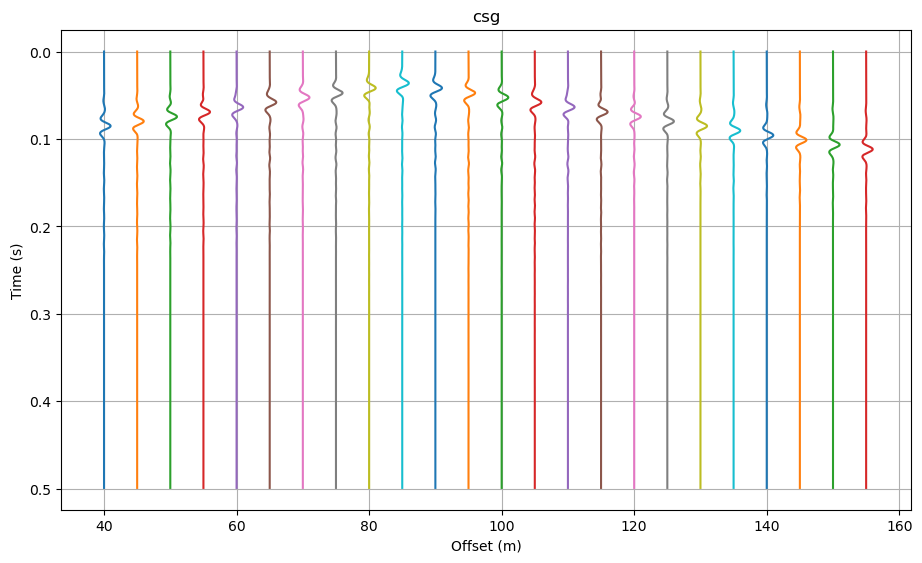

In [18]:
csg(obs[2,:,:], receiver, time, duration = 1, title = "csg", show_legend = False)

# CFWI

In [19]:
vs_c = vs_inv.clone()
vs_c.requires_grad = True

In [60]:
n_epoch = 5000
lr = 1e-2
optimizer_c = torch.optim.Adam([vs_c], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_c,
    mode = 'min',
    factor = 0.5,
    patience = 5,
)
loss_fn = torch.nn.MSELoss()
losses = []
ssim_scores = []

In [61]:
from tqdm import tqdm

In [62]:
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    optimizer_c.zero_grad()
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_c, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    
    ssim_score = structural_similarity(
        original_model.detach().cpu().numpy(),
        vs_c.detach().cpu().numpy(),
        win_size = 5,
        data_range = data_range,
    ) 
    ssim_scores.append(ssim_score)
    loss = loss_fn(syn, obs)
    losses.append(loss.item())
    loss.backward()
    optimizer_c.step()
    scheduler.step(loss.item())

100%|██████████| 5000/5000 [14:43<00:00,  5.66it/s]


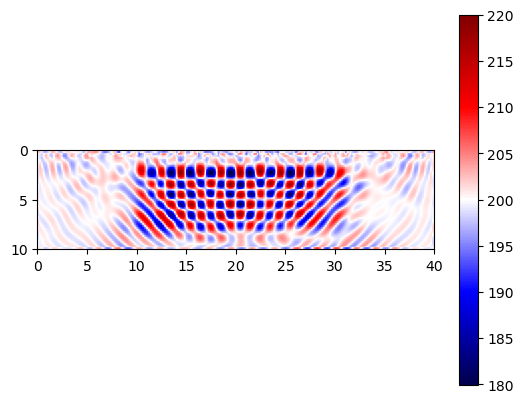

모델 복원 유사도 (SSIM 점수): 0.4970


In [63]:
plt.figure()
plt.imshow(vs_c.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_c.detach().cpu().numpy(),
    win_size = 7,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

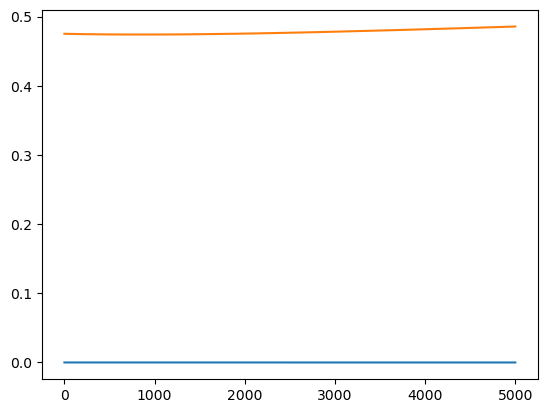

In [64]:
plt.figure()
plt.plot(losses)
plt.plot(ssim_scores)
plt.show()

# MFWI

In [25]:
def low_cut(signal: torch.Tensor,
            lowcut: float,
            dt: float,
            device: str) -> torch.Tensor:
    """
    PyTorch 기반 Low-Cut (High-Pass) 필터 (FFT 방식)

    Args:
        signal (torch.Tensor): 입력 신호 (shape: [batch, channels, time])
        lowcut (float): Low cutoff frequency (Hz)
        dt (float): 샘플링 간격 (s)
        device (str): "cpu" 또는 "cuda"
    Returns:
        torch.Tensor: Low-Cut 필터링된 신호
    """
    n = signal.shape[-1]
    freqs = torch.fft.fftfreq(n, d=dt).to(device)
    fft_sig = torch.fft.fft(signal, dim=-1)
    # lowcut 이상 주파수만 통과
    mask = freqs.abs() >= lowcut
    fft_sig = fft_sig * mask.unsqueeze(0).unsqueeze(0)
    return torch.fft.ifft(fft_sig, dim=-1).real.squeeze(0)

In [26]:
vs_m = vs_inv.clone()
vs_m.requires_grad = True

f = [20, 40, 60, 80, 100]
n_epoches = [500, 1000, 1500, 2000, 2500]
lr = 1e-2
optimizer_m = torch.optim.Adam([vs_m], lr=lr)
scheduler_m = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_m,
    mode='min',
    factor = 0.5,
    patience = 5,
)
loss_fn_m = torch.nn.MSELoss()
losses_m = []

In [27]:
for f0, n_epoch in zip(f, n_epoches):
    # obs_low는 루프 밖이나 맨 위에서 한 번만 계산해도 됩니다.
    obs_low = low_cut(obs, f0, dt, device)
    
    for epoch in range(n_epoch):
        optimizer_m.zero_grad() # 역전파 전에 그래디언트 초기화
        
        syn = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_m, rho_f),
            grid_spacing=dx, dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot,
            receiver_locations_y=receiver_locations,
            pml_freq=f0, pml_width=[0, 10, 10, 10]
        )[-2]
        
        syn = normalized_shot_gather(syn)
        
        # 수정된 부분: syn을 필터링합니다.
        syn_low = low_cut(syn, f0, dt, device) 
        
        loss = loss_fn_m(syn_low, obs_low)
        losses_m.append(loss.item())
        
        loss.backward()
        optimizer_m.step()
        scheduler_m.step(loss.item())

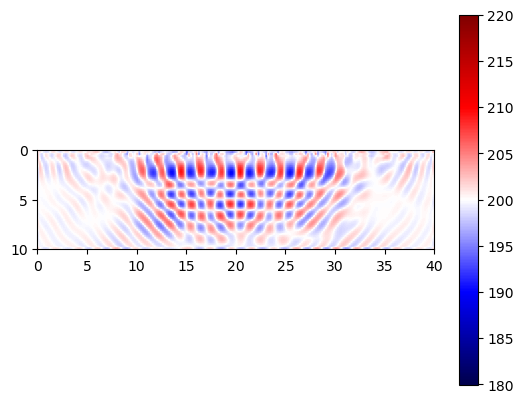

모델 복원 유사도 (SSIM 점수): 0.4941


In [28]:
plt.figure()
plt.imshow(vs_m.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_m.detach().cpu().numpy(),
    win_size = 5,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

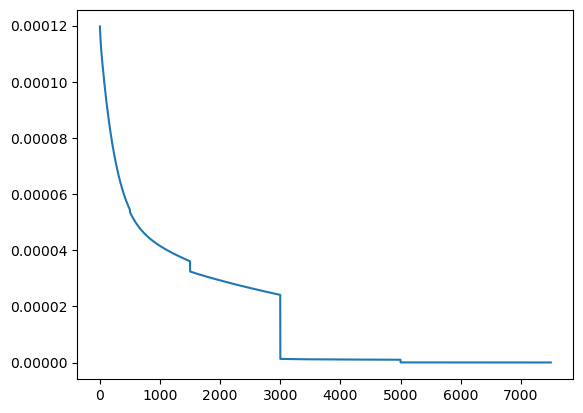

In [29]:
plt.figure()
plt.plot(losses_m)
plt.show()

# EFWI

In [30]:
import torch.nn as nn
class EnvelopeLoss(nn.Module):
    """
    관측 파형과 모델링 파형의 Envelope 차이를 계산하는 PyTorch Loss 클래스입니다.
    E(t) = (u(t)^2 + H[u(t)]^2)^(p/2)
    Loss = MSE(E_obs, E_syn)
    """
    def __init__(self, p: float = 1.0):
        """
        Args:
            p (float): Envelope 계산 시 적용할 지수 (기본값: 1.0)
        """
        super().__init__()
        if p <= 0:
            raise ValueError("지수 'p'는 양수여야 합니다.")
        self.p = p
        self.mse_loss = nn.MSELoss()

    def _calculate_envelope(self, signal: torch.Tensor) -> torch.Tensor:
        """Helper-function to compute the envelope of a signal tensor."""
        if signal.dim() != 3:
            raise ValueError("입력 신호는 3차원 텐서(n_shot, n_rec, n_t)여야 합니다.")

        n = signal.size(-1)
        # Hilbert transform via FFT
        fft = torch.fft.fft(signal, n=n, dim=-1)

        h = torch.zeros(n, device=signal.device, dtype=signal.dtype)
        h[0] = 1
        # Create frequency-domain filter for Hilbert transform
        if n % 2 == 0:
            h[1:n // 2] = 2
            h[n // 2] = 1
        else:
            h[1:(n + 1) // 2] = 2
        
        fft = fft * h.view(1, 1, -1) # Apply filter via broadcasting
        analytic_signal = torch.fft.ifft(fft, n=n, dim=-1)

        # Envelope is the magnitude of the analytic signal
        envelope = torch.sqrt(signal**2 + analytic_signal.imag**2)
        
        return envelope**self.p

    def forward(self, syn: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
        """
        모델링 파형(syn)과 관측 파형(obs)의 envelope loss를 계산합니다.
        """
        env_syn = self._calculate_envelope(syn)
        env_obs = self._calculate_envelope(obs)
        
        return self.mse_loss(env_syn, env_obs)

In [31]:
vs_e = vs_inv.clone()
vs_e.requires_grad = True

In [32]:
n_epoch = 5000
lr = 1e-2
optimizer_e = torch.optim.Adam([vs_e], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_e,
    mode = 'min',
    factor = 0.5,
    patience = 5,
)
loss_fn_e = EnvelopeLoss()
losses_e = []

In [33]:
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    optimizer_e.zero_grad()
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_e, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    
    loss = loss_fn_e(syn, obs)
    losses_e.append(loss.item())
    loss.backward()
    optimizer_e.step()
    scheduler.step(loss.item())

100%|██████████| 5000/5000 [15:03<00:00,  5.53it/s]


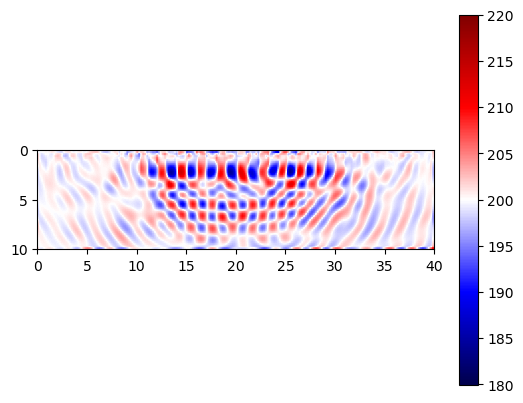

모델 복원 유사도 (SSIM 점수): 0.4099


In [34]:
plt.figure()
plt.imshow(vs_e.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax=V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_e.detach().cpu().numpy(),
    win_size = 5,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

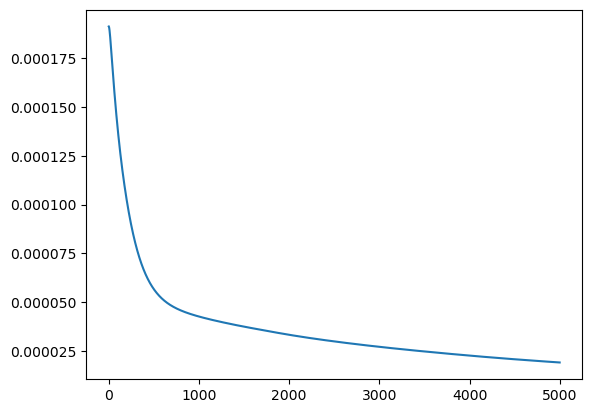

In [35]:
plt.figure()
plt.plot(losses_e)
plt.show()

# Soft-DTW

In [19]:
from tslearn.metrics import SoftDTWLossPyTorch

C:\Anaconda3\envs\FWI\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [20]:
vs_s = vs_inv.clone()
vs_s.requires_grad = True

In [23]:
from tqdm import tqdm

In [24]:
n_epoch = 1000
lr = 1e-2
optimizer_s = torch.optim.Adam([vs_s], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_s,
    mode = 'min',
    factor = 0.5,
    patience = 5,
)
loss_fn_s = SoftDTWLossPyTorch(gamma=0.1)
losses_s = []

In [25]:
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    optimizer_s.zero_grad()
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_s, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    n_shot, n_rec, n_t = syn.shape
    
    obs_re = obs.reshape(n_shot*n_rec, n_t, 1)
    syn_re = syn.reshape(n_shot*n_rec, n_t, 1)
    
    loss = loss_fn_s(syn_re, obs_re).mean()
    losses_s.append(loss.item())
    loss.backward()
    optimizer_s.step()
    scheduler.step(loss.item())

100%|██████████| 1000/1000 [15:16<00:00,  1.09it/s]


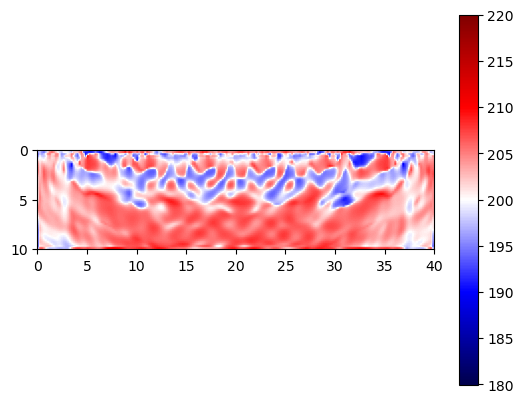

모델 복원 유사도 (SSIM 점수): 0.2728


In [26]:
plt.figure()
plt.imshow(vs_s.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax=V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_s.detach().cpu().numpy(),
    win_size = 7,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

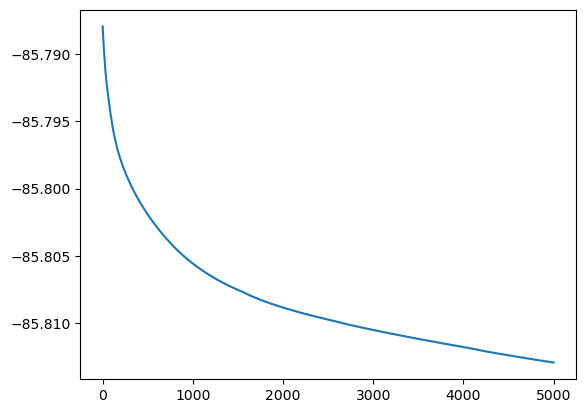

In [47]:
plt.figure()
plt.plot(losses_s)
plt.show()

# ROWI

In [41]:
def setup_objective_function_pool(all_shot_ids, misfit_function_names):
    """
    주어진 shot ID 목록과 목적 함수 이름들로 전체 풀(pool)을 생성합니다.
    """
    pool = []
    for shot_id in all_shot_ids:
        for misfit_name in misfit_function_names:
            pool.append((shot_id, misfit_name)) # (샷 ID, 목적함수 이름) 튜플로 저장
    return pool

In [42]:
vs_r = vs_inv.clone()
vs_r.requires_grad = True
n_epoch = 5000
lr = 1e-2
optimizer_r = torch.optim.Adam([vs_r], lr=lr)
scheduler_r = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_r,
    mode = 'min',
    factor = 0.5,
    patience = 5,
)
losses_r = []

In [43]:
# 1. 전체 샷(shot)의 ID 목록
# 실제로는 데이터가 담긴 객체 목록이 될 수 있습니다.
total_shot_ids = [0, 1, 2, 3, 4, 5] 

# 2. 사용자가 원하는 목적 함수를 리스트로 입력
user_choices = ["L2", "Envelope"]

# 3. 함수를 호출하여 목적 함수 풀 생성
objective_pool = setup_objective_function_pool(total_shot_ids, user_choices)

# --- 결과 확인 ---
# 총 3 (샷) * 3 (함수) = 9개의 조합으로 풀이 구성됩니다.
print(f"총 {len(objective_pool)}개의 목적 함수로 풀이 구성되었습니다.")
print(objective_pool)

총 12개의 목적 함수로 풀이 구성되었습니다.
[(0, 'L2'), (0, 'Envelope'), (1, 'L2'), (1, 'Envelope'), (2, 'L2'), (2, 'Envelope'), (3, 'L2'), (3, 'Envelope'), (4, 'L2'), (4, 'Envelope'), (5, 'L2'), (5, 'Envelope')]


In [44]:
loss_function_selector = {
    "L2" : torch.nn.MSELoss(),
    "Envelope" : EnvelopeLoss(),
}

In [45]:
batch_size = 6 # 미니배치 크기

In [54]:
for epoch in tqdm(range(n_epoch)):
    total_loss = 0.0
    torch.cuda.empty_cache()
    
    mini_batch = random.sample(objective_pool, batch_size)
    
    optimizer_r.zero_grad()
    
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_r, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    
    for shot_id, misfit_name in mini_batch:
        d_obs = obs[shot_id, :, :]
        d_syn = syn[shot_id, :, :]
        loss_func = loss_function_selector[misfit_name]
        raw_loss = loss_func(d_syn.unsqueeze(0), d_obs.unsqueeze(0))
        total_loss+=raw_loss
        
    avg_loss = total_loss / len(mini_batch)
    losses_r.append(avg_loss.item())
    
    avg_loss.backward()
    optimizer_r.step()
    scheduler_r.step(avg_loss.item())

100%|██████████| 5000/5000 [15:13<00:00,  5.48it/s]


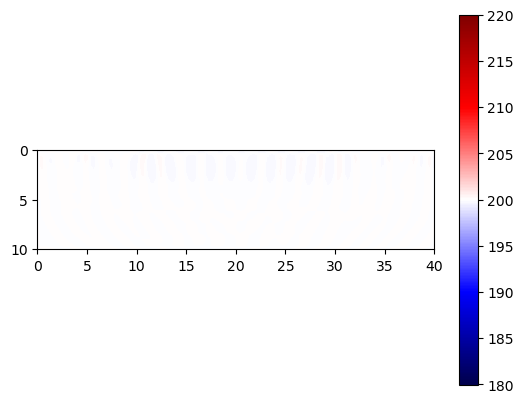

모델 복원 유사도 (SSIM 점수): 0.1210


In [55]:
plt.figure()
plt.imshow(vs_r.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax=V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_s.detach().cpu().numpy(),
    win_size = 5,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

In [57]:
ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_inv.detach().cpu().numpy(),
    win_size = 5,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

모델 복원 유사도 (SSIM 점수): 0.6054


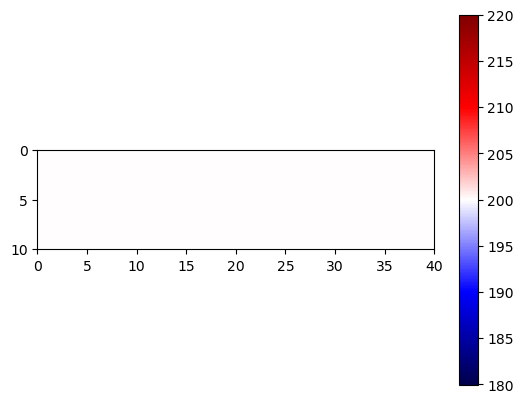

In [59]:
plt.figure()
plt.imshow(vs_inv.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax=V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()